## Movie Recommender System
This notebook consists of data preprocess, data analysis and the recommender engine implemented using simple baseline, content-based and collaborative filtering method. 

Datasets: [MovieLens 20M Dataset](https://grouplens.org/datasets/movielens/20m/)

### Data Proprocess

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Load Datasets
Load CSV files into corresponding dataframes.

In [57]:
movies = pd.read_csv('./data/ml-small/movies.csv')
ratings = pd.read_csv('./data/ml-small/ratings.csv')
tags = pd.read_csv('./data/ml-small/tags.csv')

In [58]:
#Preview Data
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [59]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.4+ KB


In [60]:
tags.head()

userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200

In [61]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
userId       3683 non-null int64
movieId      3683 non-null int64
tag          3683 non-null object
timestamp    3683 non-null int64
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [62]:
ratings.head()

userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

In [63]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
userId       100836 non-null int64
movieId      100836 non-null int64
rating       100836 non-null float64
timestamp    100836 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [64]:
#Number of Users
len(ratings.userId.unique())

610

In [65]:
#Check Missing values
print('Number of missing values in ratings:',ratings.isnull().sum().sum())
print('Number of missing values in tags:',tags.isnull().sum().sum())
print('Number of missing values in movies:',movies.isnull().sum().sum())

Number of missing values in ratings: 0
Number of missing values in tags: 0
Number of missing values in movies: 0


In [66]:
#Check Duplicate Values
print('Number of duplicate values in ratings:',len(ratings[ratings.duplicated(['movieId','userId'])].index))
print('Number of duplicate values in tags:',len(tags[tags.duplicated(['movieId','userId','tag'])].index))
print('Number of duplicate values in movies:',len(movies[movies.duplicated(['movieId'])].index))#Check Duplicate Values
print('Number of duplicate values in ratings:',len(ratings[ratings.duplicated(['movieId','userId'])].index))
print('Number of duplicate values in tags:',len(tags[tags.duplicated(['movieId','userId','tag'])].index))
print('Number of duplicate values in movies:',len(movies[movies.duplicated(['movieId'])].index))

Number of duplicate values in ratings: 0
Number of duplicate values in tags: 0
Number of duplicate values in movies: 0
Number of duplicate values in ratings: 0
Number of duplicate values in tags: 0
Number of duplicate values in movies: 0


In [67]:
#Based on my research on algorithms, timestamp is irrelevent and would be remove from the dataset.
tags = tags.drop(['timestamp'],axis=1)
ratings = ratings.drop(['timestamp'],axis=1)

In [68]:
#Split the genres
genre_set = set()
for idx,row in movies.iterrows():
    l = row.genres.split('|')
    genre_set.update(l)
print(genre_set)

{'IMAX', 'Documentary', 'Adventure', '(no genres listed)', 'Romance', 'Drama', 'Sci-Fi', 'Film-Noir', 'Thriller', 'War', 'Horror', 'Crime', 'Mystery', 'Comedy', 'Action', 'Western', 'Musical', 'Animation', 'Children', 'Fantasy'}


In [69]:
# remove '(no genres listed)' from the set
genre_set.remove('(no genres listed)')

In [70]:
def movie_genre_onehot(movie_df):
    for genre_name in genre_set:
        movie_df[genre_name] = movie_df.apply(lambda _:int(genre_name in _.genres), axis = 1 )
    movie_df = movie_df.drop('genres',axis =1)
    return movie_df

In [38]:
def weighted_rating(movie):
    v = movie.num_ratings
    R = movie.avg_rating
    m = 100 #minimum_votes required to be listed in Top50
    weighted_rating = (v/(v+m))*R+(m/(v+m))*C
    return weighted_rating

In [72]:
def calculate_avgs(movie_df):
    movie_df = movie_df.set_index('movieId')
    movie_df['num_ratings'] = ratings.groupby('movieId').size()
    mean_ratings = ratings.groupby('movieId')['rating'].mean()
    movie_df['avg_rating'] = mean_ratings    
    # the mean vote across the whole report
    C = ratings.rating.mean()
    movie_df = movie_df.reset_index()
    movie_df['weighted_avg'] = movie_df.apply(weighted_rating,axis = 1)
    return movie_df

In [73]:
def extract_year(movie_df):
    movie_df['year'] = movie_df.title.str.extract(pat=r'(\(\d\d\d\d\))',expand=True)
    movie_df['year'] = movie_df.year.str[1:-1]
    return movie_df

In [77]:
movies_feature = movies.copy()
movies_feature = extract_year(movies_feature)
movies_feature = calculate_avgs(movies_feature)
movies_feature = movie_genre_onehot(movies_feature)
movies_feature.head()

movieId                               title  year  num_ratings  avg_rating  \
0        1                    Toy Story (1995)  1995        215.0    3.920930   
1        2                      Jumanji (1995)  1995        110.0    3.431818   
2        3             Grumpier Old Men (1995)  1995         52.0    3.259615   
3        4            Waiting to Exhale (1995)  1995          7.0    2.357143   
4        5  Father of the Bride Part II (1995)  1995         49.0    3.071429   

   weighted_avg  IMAX  Documentary  Adventure  Romance   ...     Horror  \
0      3.787796     0            0          1        0   ...          0   
1      3.465027     0            0          1        0   ...          0   
2      3.418787     0            0          0        1   ...          0   
3      3.426689     0            0          0        1   ...          0   
4      3.360105     0            0          0        0   ...          0   

   Crime  Mystery  Comedy  Action  Western  Musical  Animation  Children  \
0      0        0       1       0        0        0          1         1   
1      0        0       0       0        0        0          0         1   
2      0        0       1       0        0        0          0         0   
3      0        0       1       0        0        0          0         0   
4      0        0       1       0        0        0          0         0   

   Fantasy  
0        1  
1        1  
2        0  
3        0  
4        0  

[5 rows x 25 columns]

### Data Analysis

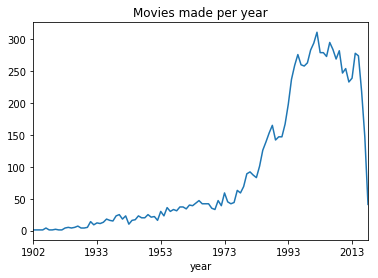

In [79]:
movies_feature.groupby('year').size().plot(title='Movies made per year')

In [82]:
#Top ten rated movies
movies_feature.sort_values(by=['num_ratings'],ascending=False).title.head(10)

314                           Forrest Gump (1994)
277              Shawshank Redemption, The (1994)
257                           Pulp Fiction (1994)
510              Silence of the Lambs, The (1991)
1939                           Matrix, The (1999)
224     Star Wars: Episode IV - A New Hope (1977)
418                          Jurassic Park (1993)
97                              Braveheart (1995)
507             Terminator 2: Judgment Day (1991)
461                       Schindler's List (1993)
Name: title, dtype: object

In [83]:
#tag analysis
print('Total number of unique tags:', len(tags.tag.unique()))

Total number of unique tags: 1589


In [84]:
#Top 10 Tags
tags.groupby('tag').size().to_frame(name='frequency').sort_values(by=['frequency'],ascending=False).head(10)

frequency
tag                         
In Netflix queue         131
atmospheric               36
thought-provoking         24
superhero                 24
Disney                    23
surreal                   23
funny                     23
religion                  22
dark comedy               21
sci-fi                    21

In [127]:
movies_feature[movies_feature['Drama']==1].sort_values(['weighted_avg'],ascending=False).title.head(10)

277     Shawshank Redemption, The (1994)
2226                   Fight Club (1999)
257                  Pulp Fiction (1994)
659                Godfather, The (1972)
314                  Forrest Gump (1994)
461              Schindler's List (1993)
6710             Dark Knight, The (2008)
922       Godfather: Part II, The (1974)
1503          Saving Private Ryan (1998)
914                    Goodfellas (1990)
Name: title, dtype: object

### Baseline Method

In [26]:
#Data Partitioning
from sklearn.model_selection import KFold
kf = KFold(n_splits = 10, shuffle = True, random_state=1234)
for train_idx,test_idx in kf.split(ratings):
    train = ratings.iloc[train_idx]
    test = ratings.iloc[test_idx]

In [45]:
#Split year from title and stats into datafram
movies_new = movies.copy()
movies_new = calculate_avgs(movies_new) 

In [46]:
movies_new.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  num_ratings  avg_rating  \
0  Adventure|Animation|Children|Comedy|Fantasy        215.0    3.920930   
1                   Adventure|Children|Fantasy        110.0    3.431818   
2                               Comedy|Romance         52.0    3.259615   
3                         Comedy|Drama|Romance          7.0    2.357143   
4                                       Comedy         49.0    3.071429   

   weighted_avg  
0      3.787796  
1      3.465027  
2      3.418787  
3      3.426689  
4      3.360105

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#User Rating Average Matrix
user_avg = ratings.groupby('userId').mean().rating.values
#Movie Rating Average Matrix
movie_avg = movies_new[['movieId','weighted_avg']]

def data_split(idx):
    data = ratings.iloc[idx]
    X = data[['userId','movieId']]
    X['u_bias'] = X.apply(lambda x: user_avg[x['userId']-1], axis=1)
    X = X.drop(['userId'],axis=1)
    X = pd.merge(X,movie_avg,on='movieId')
    X = X.drop(['movieId'],axis=1).values
    y = data.rating.values
    return (X,y)

RMSEs = []
for train_idx,test_idx in kf.split(ratings):
    train_X,train_y = data_split(train_idx)
    test_X, test_y = data_split(test_idx)    
    clf = LinearRegression()
    clf.fit(train_X,train_y)
    y_pred = clf.predict(test_X)
    rmse = np.sqrt(mean_squared_error(y_pred,test_y))
    RMSEs.append(rmse)
    print('RMSE: ',rmse)
print('The average of rmse is', np.mean(RMSEs))

RMSE:  1.042592009041935
RMSE:  1.0504471358505316
RMSE:  1.0386264206084166
RMSE:  1.049384149259346
RMSE:  1.0522461872327022
RMSE:  1.0443170119984602
RMSE:  1.024050141009059
RMSE:  1.0385977498056458
RMSE:  1.0399070153938026
RMSE:  1.0448155066265055
The average of rmse is 1.0424983326826405


### Collaborative Filtering Approach
Collaborative filtering (CF) technique is very commonly used in recommendation systems. CF models work based on the assuption that similar users share the same interest and that similar items are liked by a user. Matrix Factorization(MF) is one class of CF used in recommender systems.

###  Singular Value Decomposition (SVD)
SVD is a latent-factor approach of MF methods. Feature space is reduced to capture user-item correlations. Below is a diagram of SVD algorithms.
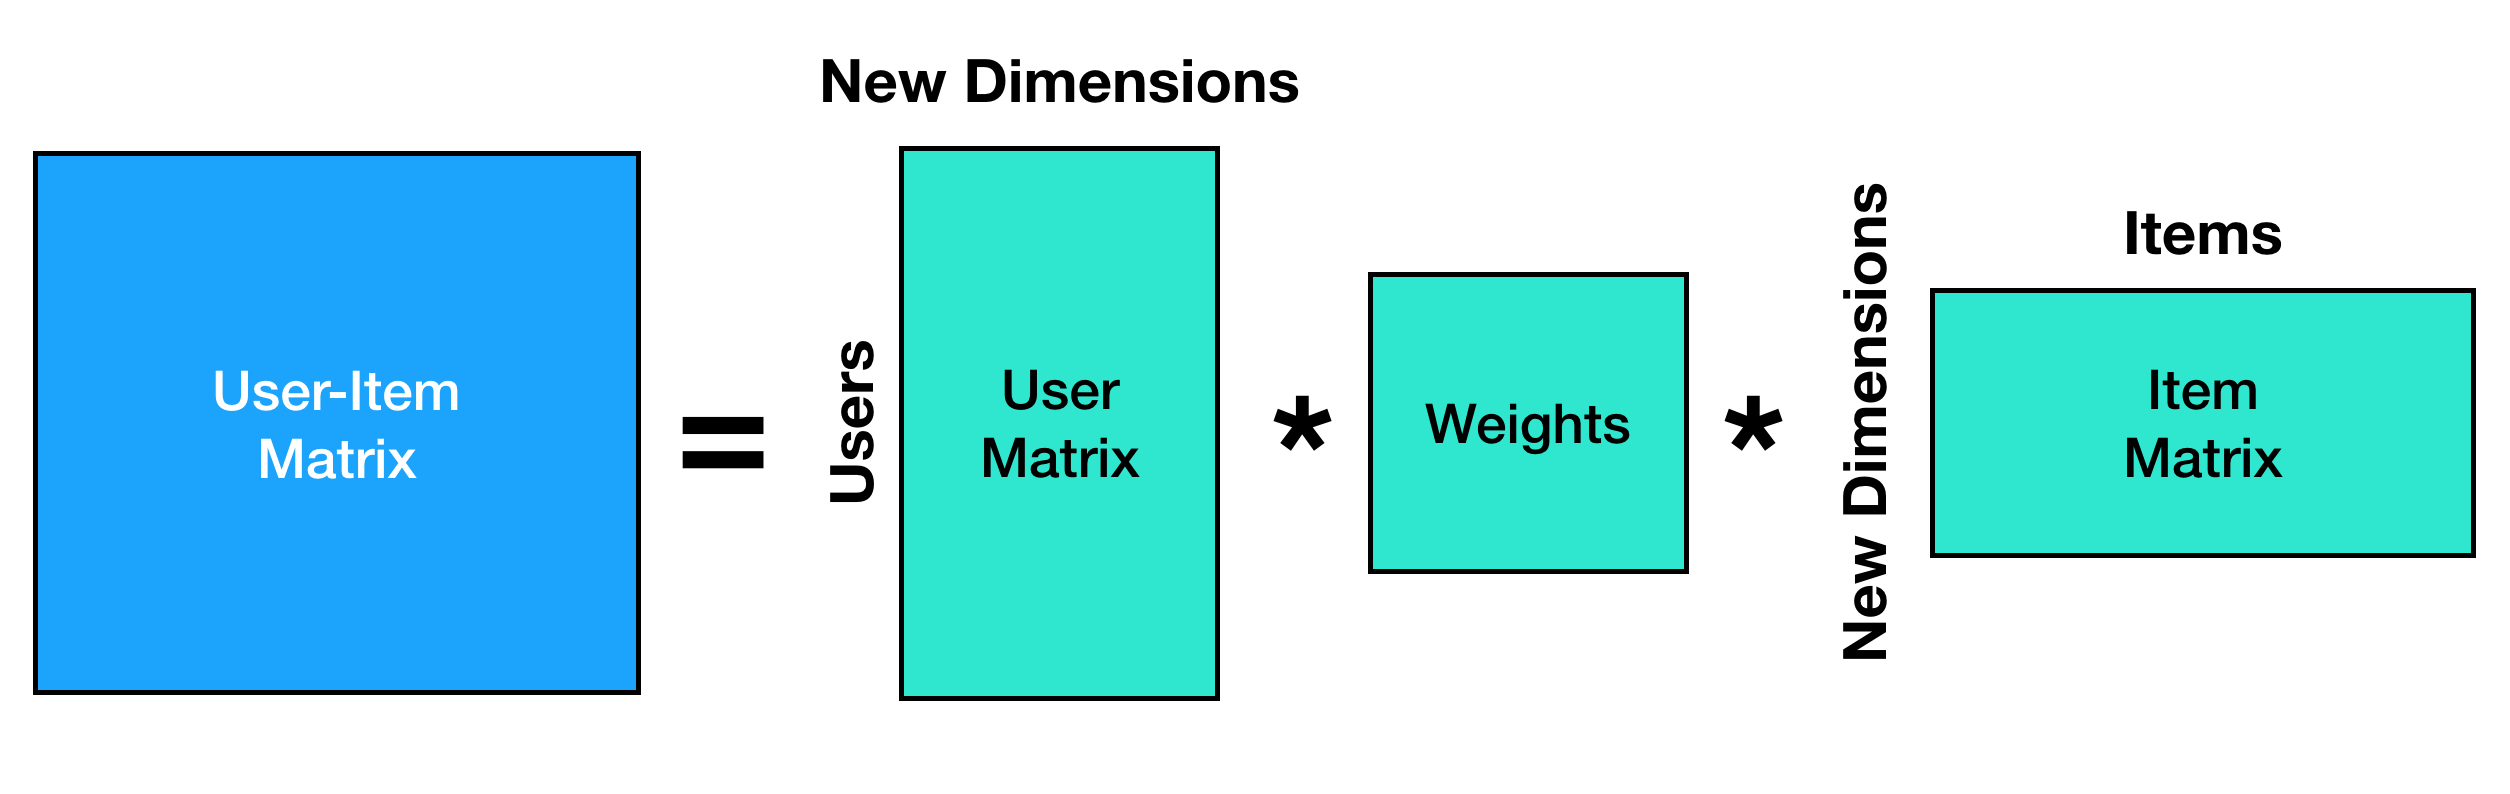

In [89]:
from surprise import Reader,Dataset
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import GridSearchCV

#Basic SVD implementation from Surprise : https://surprise.readthedocs.io/en/stable/index.html
reader = Reader(rating_scale=(1,5))
R = Dataset.load_from_df(ratings,reader)

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005], 'reg_all': [0.4, 0.6]}
svd_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=10, refit=True)

svd_gs.fit(R)

print(svd_gs.best_score['rmse'])
print(svd_gs.best_params['rmse'])

0.8876008566236389
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [45]:
# Surprise Implementation of Non-negative Matrix Factorization
import surprise
from surprise.model_selection import cross_validate

algo2 = surprise.NMF()
cross_validate(algo2,R,cv=10)

{'test_rmse': array([0.90335782, 0.90793115, 0.92540687, 0.91106611, 0.91105485,
        0.91139667, 0.91423155, 0.90460128, 0.91150793, 0.92276759]),
 'test_mae': array([0.69509491, 0.69444536, 0.7114219 , 0.69866845, 0.69884661,
        0.69324839, 0.69925571, 0.69213991, 0.69768433, 0.70674433]),
 'fit_time': (4.254696607589722,
  4.165010213851929,
  4.1646342277526855,
  4.137763500213623,
  4.376805305480957,
  4.942785024642944,
  4.509955406188965,
  4.33752703666687,
  4.420603036880493,
  4.480296850204468),
 'test_time': (0.03798842430114746,
  0.03692197799682617,
  0.03761005401611328,
  0.0408787727355957,
  0.05138969421386719,
  0.0369877815246582,
  0.0367739200592041,
  0.03636813163757324,
  0.0386347770690918,
  0.04852557182312012)}

#### Get Top-N Recommendations

In [91]:
#Build testset
test = R.build_full_trainset().build_anti_testset()
#Get predictions
pred = svd_gs.test(test)

In [92]:
movies = pd.read_csv('processed_data/movies_new.csv')

def find_top_n(userId , n , pred):
    top_n=[]
    for uid,mid,_,est,_ in pred:
        if (uid==userId):
            top_n.append((mid,est))
    
    top_n.sort(key=lambda x:x[1], reverse=True)
    print ('Top N recommendations:')
    for i in range(n):
        mid = top_n[i][0]
        score = top_n[i][1]
        movie_title = movies[movies['movieId']==mid].title.values
        print ('Title: ', movie_title[0])
        
find_top_n(1,10,pred)

Top N recommendations:
Title:  Shawshank Redemption, The (1994)
Title:  Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
Title:  Godfather, The (1972)
Title:  Lawrence of Arabia (1962)
Title:  Rear Window (1954)
Title:  Departed, The (2006)
Title:  Godfather: Part II, The (1974)
Title:  Casablanca (1942)
Title:  Cool Hand Luke (1967)
Title:  Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)


### Content-Based Approach 

In [94]:
ratings.head()

userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0

In [124]:
def user_profile(Id):
    viewed = ratings[ratings.userId==Id]
    viewed = viewed.merge(movies_feature,on='movieId')
    genres = np.zeros(len(genre_set))
    for i in range(len(genre_set)):
        num_of_g = viewed[genre].sum()
        genres[i] = num_of_g

    genre_list = list(genre_set)
    fav_3 = np.argsort(genres)[-3:]
    return [genre_list[fav_3[2]],genre_list[fav_3[1]],genre_list[fav_3[0]]]    

In [126]:
print('Get user 1\'s favorite genres:', user_profile(1))

Get user 1's favorite genres: ['Fantasy', 'War', 'Documentary']


In [131]:
def recommend_top_from_genre(genre,Id):
    viewed = ratings[ratings.userId==Id].movieId
    not_viewed = movies_feature.set_index('movieId')
    not_viewed = not_viewed.drop(viewed)
    print(not_viewed[not_viewed[genre]==1].sort_values(['weighted_avg'],ascending=False).title.head(5))    

In [133]:
Id = 1
fav_genres = user_profile(Id)
for g in fav_genres:
    print('Recommendations based on genre: ',g)
    recommend_top_from_genre(g,Id)

Recommendations based on genre:  Fantasy
movieId
4993    Lord of the Rings: The Fellowship of the Ring,...
7153    Lord of the Rings: The Return of the King, The...
5952        Lord of the Rings: The Two Towers, The (2002)
5618    Spirited Away (Sen to Chihiro no kamikakushi) ...
1199                                        Brazil (1985)
Name: title, dtype: object
Recommendations based on genre:  War
movieId
750      Dr. Strangelove or: How I Learned to Stop Worr...
2324            Life Is Beautiful (La Vita è bella) (1997)
68157                          Inglourious Basterds (2009)
1204                             Lawrence of Arabia (1962)
1233                          Boot, Das (Boat, The) (1981)
Name: title, dtype: object
Recommendations based on genre:  Documentary
movieId
246                                     Hoop Dreams (1994)
162                                           Crumb (1994)
5669                          Bowling for Columbine (2002)
7156     Fog of War: Eleven Lessons f